MHz per volt 584 -641


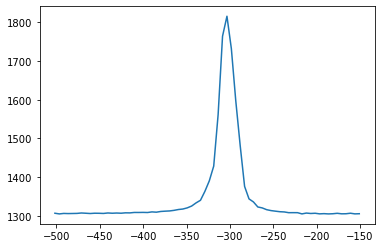

In [66]:
import numpy as np
from MakeMHzScale import  MHzScale
from astropy.io import fits
import matplotlib.pyplot as plt
import scipy.special as spf
import scipy.optimize as spo
angle=13*np.pi/180
kb=1.38e-23
m=1.16e-26

I0=(10e-6)*100**2 #convert to watts/ m^2

sigmaLaserJitterMeasured=1.6 #MHz. measured on day of data taking

fitsFile=fits.open('run43Far.fits') #9_23_21
imagesArrRaw=fitsFile[0].data
imagesArrRaw=imagesArrRaw.astype(float) #need to convert to float from int16
imagesArrRaw=np.flip(imagesArrRaw,axis=1)


DAQData=np.loadtxt('run43DAQData.csv',delimiter=',')
MHzArr=MHzScale(DAQData).make_MHZ_Scale(False)
startVolt,stopVolt=-1.5,-.9

galvoVoltArr=DAQData[:,0]
P=np.polyfit(galvoVoltArr,MHzArr, 1)
imageVoltArr=np.linspace(startVolt,stopVolt,num=len(imagesArrRaw))
imagesMHzArr=P[1]+P[0]*imageVoltArr

plt.plot(imagesMHzArr,np.mean(np.mean(imagesArrRaw,axis=1),axis=1))
plt.show()

In [67]:
#scattering rate
lam=671e-9
freq0=3e8/lam
h=6.626e-34
crossSection=6*np.pi*(lam/(2*np.pi))**2
scatteringRate=(I0/(h*freq0))*crossSection
L=3e-2 #upper bound on length of laser
t=L/200.0
scatteringRate*t

10.884977098913401

In [68]:
import warnings
import time
def extract_Sub_Image_From_Fits_Coords(images,xFitsCoord,yFitsCoord,xWidth,yWidth,overRideDataTypeWarning=False):
    #images: A list,array or single images from which to extract the subimages
    #xFitsCoord: x coordinate in fits file of box center
    #yFitsCoord: y coordinate in fits file of box center
    #xWidth: x width of box in fits file
    #yWidth: y widht of box in fits file
    if not all(np.issubdtype(type(val),int) for val in [xFitsCoord,yFitsCoord,xWidth,yWidth]): #Have to do an annoying
        # trick to accept numpy and python integers for these values
        raise Exception("coords and dimensions must bet integers")
    if isinstance(images,np.ndarray):
        imageArr=images
    else:
        imageArr=np.array(images)
    if overRideDataTypeWarning==False and imageArr.dtype != 'float64':
        warnings.warn('\n The data type of your image is not a float. \n It is very unlikely this was intentional \n'
                      'This can have serious unintended consequences if you don\'t understand integer behaviour clearly \n '
                      'You can')
        time.sleep(5.0)
    singleImage=False
    if len(imageArr.shape)==2: # if a single image instead of a movie
        singleImage=True
        imageArr=np.array([imageArr]) #convert into a one frame movie
    imageSizeY, imageSizeX=imageArr[0].shape
    if xWidth%2!=1 or yWidth%2!=1:
        raise Exception('Fit file box dimensions must be even for this to work simply')
    if not (xFitsCoord+xWidth//2<imageSizeX and xFitsCoord-xWidth//2>0 ):
        raise Exception("box in x dimension exceeds image bounds")
    if not (yFitsCoord+yWidth//2<imageSizeY and yFitsCoord-yWidth//2>0 ):
        raise Exception("box in y dimension exceeds image bounds")
    xStartFits=xFitsCoord-(xWidth-1)//2
    xEndFits=xFitsCoord+(xWidth-1)//2
    xStartNP=xStartFits-1
    xEndNP=xEndFits

    yStartFits=yFitsCoord-(yWidth-1)//2
    yEndFits=yFitsCoord+(yWidth-1)//2

    yStartNP=(imageSizeY-yEndFits)
    yEndNP=(imageSizeY-yStartFits)+1
    subImages=imageArr[:, yStartNP:yEndNP, xStartNP:xEndNP]
    if singleImage==True:
        subImage=subImages[0]
        return subImage
    else:
        return subImages

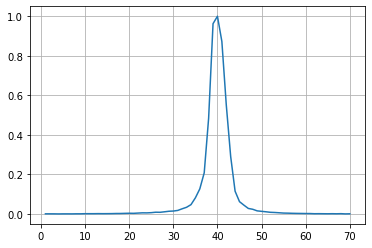

In [73]:
%matplotlib inline
background=imagesArrRaw[0]
imagesArr=imagesArrRaw-background
xFits=150
yFits=145
width=3

subImage=extract_Sub_Image_From_Fits_Coords(imagesArr,xFits,yFits,width,width)
spectralProfile=np.mean(np.mean(subImage,axis=1),axis=1)

spectralProfile=spectralProfile/spectralProfile.max()

plt.plot(np.arange(1,71),spectralProfile)
plt.grid()
plt.show()

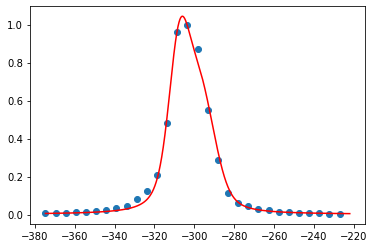

sigma: 4.111099453239524
T: 6.3
velocity FHWM: 6.5 m/s


(3.7935160046080894, 4.111099453239524)

In [96]:
#need multi peak fit
import globalVariables as gv
def _voigt(f,f0,a,sigma):
    #units must be consistent!!
    #f, frequency value
    #a, height of voigt
    #f0, center frequency
    #gamma, FWHM of the lorentzian
    gammaFWHM=5.86
    gammaHWHM=gammaFWHM/2.0
    x=f-f0
    v0=spf.voigt_profile(0,sigma,gammaHWHM)
    v=a*spf.voigt_profile(x,sigma,gammaHWHM)/v0
    return v

def _multi_Voigt(freq, freq0, a,b, sigma,sigmaLaserJitter=sigmaLaserJitterMeasured):
    aRatio=2*gv.F2F1Ratio  #ratio of intensity of f=2 to f=1. First number is power ratio in sideband. Second
    # fraction is ratio of hyperfine transitions (see globalVariable.py for more info in the comments for
    #F2F1Ratio).
    assert sigma>=0.0 and a>0.0
    sigma=np.sqrt(sigma**2+sigmaLaserJitter) #laser jitter
    a2=(aRatio/(aRatio+1))*a #I do some funny business here to try and get the parameter "a" to more closely match
    #the total height. a2/a1 still equals the parameter "aRatio", but now they also add up the parameter "a"
    a1=a*1/(aRatio+1) #same funny business
    val=0.0
    #F=2 transition
    val+=a2*_voigt(freq, freq0+gv.F1Sep/1E6, gv.S21, sigma)
    val+=a2*_voigt(freq, freq0+gv.F2Sep/1E6, gv.S22, sigma)
    val+=a2*_voigt(freq, freq0+gv.F3Sep/1E6, gv.S23, sigma)
    # F=1 transition
    val+=a1*_voigt(freq, freq0+gv.F0Sep/1E6, gv.S10, sigma)
    val+=a1*_voigt(freq, freq0+gv.F1Sep/1E6, gv.S11, sigma)
    val+=a1*_voigt(freq, freq0+gv.F2Sep/1E6, gv.S12, sigma)
    return val+b
guess=[imagesMHzArr[np.argmax(spectralProfile)],spectralProfile.max(),0.0,5.0]
bounds=[(-np.inf,0.0,-np.inf,0.0),(np.inf,np.inf,np.inf,np.inf)]
params,pcov=spo.curve_fit(_multi_Voigt,imagesMHzArr,spectralProfile,p0=guess,bounds=bounds)
# params[-1]=2.0
perr = np.sqrt(np.diag(pcov))
%matplotlib inline
indexStart=25
indexEnd=15
xPLot=np.linspace(imagesMHzArr[indexStart],imagesMHzArr[-indexEnd],10_000)
plt.scatter(imagesMHzArr[indexStart:-indexEnd],spectralProfile[indexStart:-indexEnd])
plt.plot(xPLot,_multi_Voigt(xPLot,*params),c='r')
plt.show()
sigmaMHz=params[-1]
sigmaMHz=sigmaMHz/np.cos(angle) #account for angle
sigmaMHz_Error=perr[-1]/np.cos(angle)

sigmaVelocity=(sigmaMHz+0*perr[-1])/1.5
T=sigmaVelocity**2*m/kb
print('sigma:',sigmaMHz)
print('T:',np.round(1e3*T,1))
print('velocity FHWM:',np.round(2.355*sigmaVelocity,1),'m/s')
np.sqrt(sigmaMHz**2-(np.sin(angle)*8.0)**2)/np.cos(angle),sigmaMHz

### Plot of fit

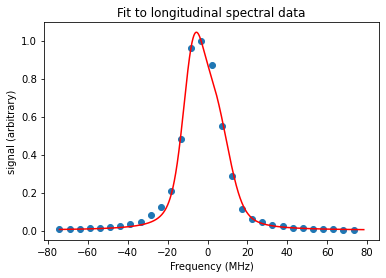

In [97]:
xPLot=np.linspace(imagesMHzArr[indexStart],imagesMHzArr[-indexEnd],10_000)
plt.scatter(imagesMHzArr[indexStart:-indexEnd]-params[0],spectralProfile[indexStart:-indexEnd])
plt.plot(xPLot-params[0],_multi_Voigt(xPLot,*params),c='r')
plt.xlabel('Frequency (MHz)')
plt.ylabel("signal (arbitrary)")
plt.title('Fit to longitudinal spectral data')

plt.show()

### Plot of individual profiles

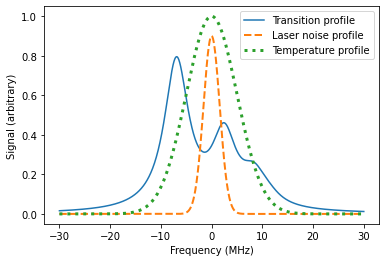

In [102]:
# profile
def laser_Gauss(x):
    return .9*np.exp(-.5*(x/sigmaLaserJitterMeasured)**2)
def temp_Gauss(x,sigma):
    return np.exp(-.5*(x/sigma)**2)
def transition_Prof(x):
    sigmaTemperature=1e-12
    return 1.3*_multi_Voigt(x,0.0,1,0.0,sigmaTemperature,sigmaLaserJitter=0.0)
sigmaTemp=5.0
freqArr=np.linspace(-30,30,1000)
plt.plot(freqArr,transition_Prof(freqArr),label='Transition profile')
plt.plot(freqArr,laser_Gauss(freqArr),linestyle='--',linewidth=2,label='Laser noise profile')
plt.plot(freqArr,temp_Gauss(freqArr,sigmaTemp),linestyle=':',linewidth=3,label='Temperature profile')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Signal (arbitrary)')
plt.legend()
plt.show()

In [116]:
P=153e-9
wx=2.83e-2
wy=.59e-3
I0=2*P/(np.pi*wx*wy)
lam=671e-9
freq0=3e8/lam
h=6.626e-34
crossSection=6*np.pi*(lam/(2*np.pi))**2
scatteringRate=(I0/(h*freq0))*crossSection
L=1.25*wx #upper bound on length of laser
t=L/200.0
print('maximum amount of cycles: ',scatteringRate*t)

maximum amount of cycles:  0.7487482495545887


In [113]:
import sympy as sym
I0,w,x=sym.symbols('I0 w x',real=True)
func=I0*sym.exp(-2*x**2/w**2)
sym.N(sym.integrate(func,(x,-sym.oo,sym.oo))).args[0].args[0]

1.2533141373155*I0*w